In [ ]:
import pypsa
import pandas as pd
import numpy as np
import os
import pypsatopo
from xlsxwriter import Workbook

In [ ]:
solver = "cbc"

In [ ]:
# Create empty PyPSA network
n = pypsa.Network()

In [ ]:
# Set snapshots to the year 2023 and at hourly resolution
snapshots = pd.date_range("01-01-2019", "01-01-2020", freq="h", inclusive="left")
n.set_snapshots(snapshots)

In [ ]:
# To calculate annualized capital expenditure
def calculate_annualised_capex(capex: float, interest: float, lifetime: int):
    crf = (
        interest * (1 + interest) ** lifetime / ((1 + interest) ** lifetime - 1)
    )  # Capital recovery factor
    return capex * crf

In [ ]:
#Removal of certain components

#n.remove(class_name="Link", name="electricity_flow")
#n.remove(class_name="Bus", name="electricity_storage")
# n.remove(class_name="Link", name="haber_bosch")

In [ ]:
name="JiLi_BC"
turbine="VE"

<Axes: xlabel='snapshot'>

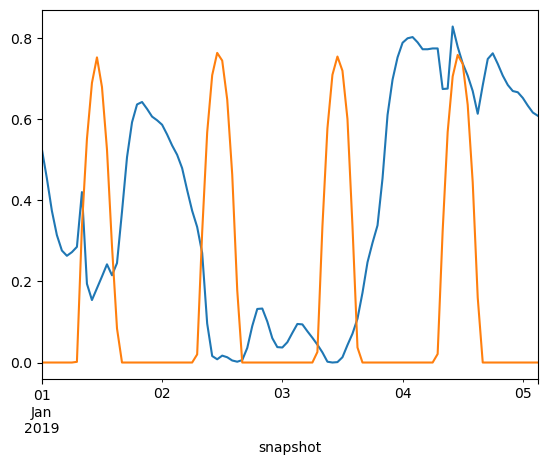

In [ ]:
# Import an example of wind daily pattern
wind_pattern = pd.read_csv(f"{name}_wind_{turbine}.csv")["daily pattern"]
# annual time-series availability of onshore wind (just a simplified example)
wind_profile = pd.Series(list(wind_pattern), index=n.snapshots)

# Import an example of solar daily pattern
solar_pattern = pd.read_csv(f"{name}_PV.csv")["daily pattern"]
# annual time-series availability of solar (just a simplified example)
solar_profile = pd.Series(list(solar_pattern), index=n.snapshots)

# Import an example of wind daily pattern
#load_pattern = pd.read_csv("/data/weather data/example_industrial_h2_demand_daily_pattern.csv")["daily pattern"]
# annual time-series availability of onshore wind (just a simplified example)
#load_profile = pd.Series(list(load_pattern)*365, index=n.snapshots)

# Print first few values to verify
wind_profile.head(100).plot()
solar_profile.head(100).plot()

In [ ]:
# create the buses needed for the ammonia system
n.add(class_name="Bus", name="electricity", carrier="electricity")

#n.add(class_name="Bus", name="electricity_storage", carrier="electricity", overwrite=True)

# hydrogen buses
n.add(class_name="Bus", name="hydrogen", carrier="hydrogen")
n.add(class_name="Bus", name="hydrogen_storage", carrier="hydrogen")
# ammonia buses
n.add(class_name="Bus", name="ammonia", carrier="ammonia")
n.add(class_name="Bus", name="ammonia_storage", carrier="ammonia")

n.buses

attribute,v_nom,type,x,y,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network
Bus,,,,,,,,,,,,
electricity,1.0,,0.0,0.0,electricity,,1.0,0.0,inf,PQ,,
hydrogen,1.0,,0.0,0.0,hydrogen,,1.0,0.0,inf,PQ,,
hydrogen_storage,1.0,,0.0,0.0,hydrogen,,1.0,0.0,inf,PQ,,
ammonia,1.0,,0.0,0.0,ammonia,,1.0,0.0,inf,PQ,,
ammonia_storage,1.0,,0.0,0.0,ammonia,,1.0,0.0,inf,PQ,,


In [ ]:
#create the end demand load for ammonia

#n.remove(class_name="Load", name="hydrogen_load")
n.add(class_name="Load", name="ammonia_load", bus="ammonia", p_set=100, overwrite=True) 
#n.add(class_name="Load", name="hydrogen_load", bus="hydrogen", p_set=100, carrier="hydrogen", type="hydrogen_load", overwrite=True)
# or p_set=load_profile
n.loads


attribute,bus,carrier,type,p_set,q_set,sign
Load,,,,,,
ammonia_load,ammonia,,,100.0,0.0,-1.0


In [ ]:
#exchange rates
eur_to_usd = 1.1
usd_to_cny = 7.0774

# interest rate / discount rate
interest = 0.0563 # according to BOA PTX; original value: 0.05

In [ ]:
# create the generators for wind, based on techno-economic parameters
# Onshore Wind's techno-economic parameters are given as:
lifetime = 20
interest = 0.0563 # according to BOA PTX; original value: 0.05
CAPEX = 4500 * 1000 / usd_to_cny # $/MW
FOM = 2 #% of CAPEX
VOM = 0 # $/MWh variable
efficiency = 1

annualized_capex = calculate_annualised_capex(CAPEX, interest, lifetime)

n.add(
    class_name="Generator", 
    name="onshore_wind",
    bus="electricity",
    carrier="wind",
    p_nom_extendable=True,
    p_nom_min=100, # MW
    #p_nom_max=500, # MW
    capital_cost=annualized_capex + FOM/100 * CAPEX, #$/MW
    marginal_cost=VOM, #$/MWh
    efficiency=efficiency,
    lifetime=lifetime,
    p_max_pu=wind_profile
)

In [ ]:
# create the generator for solar, based on techno-economic parameters
# Solar's techno-economic parameters are given as:
lifetime = 25
interest = 0.0563 # according to BOA PTX; original value: 0.05
CAPEX = 3940 * 1000 / usd_to_cny # $/MW
FOM = 1 #% of CAPEX
VOM = 0 # $/MWh variable
efficiency = 1

annualized_capex = calculate_annualised_capex(CAPEX, interest, lifetime)

n.add(
    class_name="Generator", 
    name="solar",
    bus="electricity",
    carrier="solar",
    p_nom_extendable=True,
    p_nom_min=50,
    #p_nom_max=500, # MW
    capital_cost=annualized_capex + FOM/100 * CAPEX, #$/MW
    marginal_cost=VOM, #$/MWh
    efficiency=efficiency,
    lifetime=lifetime,
    p_max_pu=solar_profile
)

In [ ]:
#create the generator for hybrid supply

#n.add(class_name="Generator", name="hybrid_wind_solar", bus="electricity", carrier="wind", overwrite=True)

n.generators

attribute,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,...,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
onshore_wind,electricity,PQ,,0.0,0.0,True,100.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
solar,electricity,PQ,,0.0,0.0,True,50.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0


In [ ]:
# create hydrogen storage tank

#Techno-economic data for hydrogen storage tank
lifetime = 20
interest = 0.0563 # according to BOA PTX; original value: 0.05
CAPEX = 18 * 1000 # $/MWh (25th percentile of Agora Industry H2 compressed storage tank range: https://public.flourish.studio/visualisation/16577546/); original value: 4779.9527
FOM = 0.43 #%/year; unchanged

annualized_capex = calculate_annualised_capex(CAPEX, interest, lifetime)

n.add(
      class_name="Store",
      name="hydrogen_tank",
      type="hydrogen_tank",
      bus="hydrogen_storage",
      carrier="hydrogen",
      capital_cost=annualized_capex + FOM/100 * CAPEX,
      e_nom_extendable=True,
      e_cyclic=True,
      marginal_cost=1,#$/MWh 
      overwrite=True
)


In [ ]:
# create ammonia storage tank
# Ammonia tank's techno-economic parameters are given as:
eur_to_usd = 1.1
lifetime = 20
interest = 0.0563

CAPEX = 166.8201 * eur_to_usd # $/MWh
FOM = 4.0 # %/year

annualized_capex = calculate_annualised_capex(CAPEX, interest, lifetime)


n.add(
    class_name="Store", 
    name="ammonia_tank",
    type="ammonia_tank",
    bus="ammonia_storage", 
    carrier="ammonia",
    e_nom_extendable=True,
#    e_nom_max=5000,
    e_cyclic=True,
#    e_initial=0,
    capital_cost= annualized_capex * FOM/100 * CAPEX,
    marginal_cost=1, 
    overwrite=True
)

n.stores

attribute,bus,type,carrier,e_nom,e_nom_mod,e_nom_extendable,e_nom_min,e_nom_max,e_min_pu,e_max_pu,...,p_set,q_set,sign,marginal_cost,marginal_cost_quadratic,capital_cost,standing_loss,build_year,lifetime,e_nom_opt
Store,,,,,,,,,,,,,,,,,,,,,
hydrogen_tank,hydrogen_storage,hydrogen_tank,hydrogen,0.0,0.0,True,0.0,inf,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,1599.915161,0.0,0,inf,0.0
ammonia_tank,ammonia_storage,ammonia_tank,ammonia,0.0,0.0,True,0.0,inf,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,113.928200,0.0,0,inf,0.0


In [ ]:
# Techno-economic parameters of a lithium ion battery storage:

lifetime = 12.5  # years (average: 10-15); https://greencubes.com/in-the-news/why-lithium-is-taking-over-stationary-energy-storage/
interest = 0.0563  # unit: -
CAPEX = 160 * 1000  # $/MW; original: 600 # 80USD / kWh storage (Nov 2024), assuming 2Ah storages. Source: https://www.energy-storage.news/mind-blowing-bids-power-chinas-16gwh-bess-tender-state-owned-firms-market-share/
FOM = 1.5  # $/MW per year (between 1% and 2% of the CAPEX)
VOM = 0  # $/MWh
fuel_cost = 0  # $/MWh_th per unit water consumed
efficiency_store = 0.965  # assuming similar storing and discharging efficiencies #https://blog.discoverbattery.com/understanding-charging
efficiency_dispatch = 0.965  # assuming similar storing and discharging efficiencies

annualized_capex = calculate_annualised_capex(CAPEX, interest, lifetime)

n.add(
    class_name="StorageUnit",
    name="battery",
    bus="electricity",
    marginal_cost= VOM + fuel_cost,
    capital_cost=annualized_capex + FOM/100 * CAPEX,
    p_nom_extendable=True,
    efficiency_store=efficiency_store,
    efficiency_dispatch=efficiency_dispatch,
    p_max_pu=1,  # Discharging availability
    p_min_pu=-1,  # Charging availability
    max_hours=2,  # energy-to-power ratio assumption is 2Ah
#    state_of_charge_initial=100,
    overwrite=True
)


#LCOH MAP is behaving in the same way because hydrogen and ammonia storage are cheaper
# set p_min if you want to really use batteries.

In [ ]:
#create the links for electrolysers, ammonia synthesis, electricity flow and hydrogen flow
"""
n.add(
    class_name="Link", 
    name="electricity_flow",
    bus0="electricity",
    bus1="electricity_storage",
    p_nom_extendable=True, # allow flexible capacity expansion
    marginal_cost=1, #$/MWh 
    efficiency=1,
    p_min_pu=-1, #bi-directional flow
    overwrite=True
)
"""
n.add(
    class_name="Link", 
    name="hydrogen_flow",
    bus0="hydrogen",
    bus1="hydrogen_storage",
    p_nom_extendable=True, # allow flexible capacity expansion
    marginal_cost=1, #$/MWh 
    efficiency=1,
    p_min_pu=-1, #bi-directional flow
    overwrite=True
)

n.add(
    class_name="Link", 
    name="ammonia_flow",
    bus0="ammonia",
    bus1="ammonia_storage",
    p_nom_extendable=True, # allow flexible capacity expansion
    marginal_cost=1, #$/MWh 
    efficiency=1,
    p_min_pu=-1, #bi-directional flow
    overwrite=True
)

n.links

attribute,bus0,bus1,type,carrier,efficiency,build_year,lifetime,p_nom,p_nom_mod,p_nom_extendable,...,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt
Link,,,,,,,,,,,,,,,,,,,,,
hydrogen_flow,hydrogen,hydrogen_storage,,,1.0,0,inf,0.0,0.0,True,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
ammonia_flow,ammonia,ammonia_storage,,,1.0,0,inf,0.0,0.0,True,...,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0


In [ ]:
#create the link for the electrolyser

# Electrolyser's techno-economic parameters are given as:
lifetime = 20
interest = 0.0563
#water_cost = 1.8 # EUR/m3_H2O --> this includes the water treatment costs applied to the seawater
#water_demand_ratio= 21 # kgH2O/kgH2 --> how much water is needed to produce 1 kg of hydrogen?

CAPEX = 600.34 *1000 # $/MW
stackreplacement_CAPEX = 0.31 * CAPEX # $/MW
stackreplacement_lifetime = 10 # years
FOM = 2 # %/year or CAPEX
VOM = 0 # $/MWh variable
efficiency = 0.59
ramp_limit_up= 0.3 #%/hour Source #4: Bodke et al (2021)
ramp_limit_down = 0.3 #%/hour Source #4: Bodke et al (2021)
ramp_limit_start_up = 0.15 #%/hour Source #4: Bodke et al (2021)
min_up_time = 2 #hours Source #4: Bodke et al (2021)

"""
# Calculate marginal cost for water consumption
# marginal cost [USD/MWh] = 
# water_cost [EUR/m3_H2O] * eur_to_usd [USD/EUR] / 1000 [kgH2O/m3_H2O] * water_demand_ratio [kgH2O/kgH2] / (33.33/1000 [MWh/kgH2])
water_cost = ((water_cost * eur_to_usd / 1000) * water_demand_ratio) / (33.33 / 1000) # 1 kgH2 = 33.33 kWh = 0.03333 MWh

# Add a compressor to pressurize hydrogen produced by the electrolyser and feed it to the hydrogen storage
# 1. Calculate the specific electricity consumption for compressor in kWh_el/kWh_H2. Assumption: 0.6 [kWh_el/kgH2]
# 2. Calculate the specific energy consumption for the electrolyser in kWh_el/kWh_H2. This corresponds to the reciprocal of the electrolyser's efficiency.
# 3. The sum of the two specific energy consumptions represents the total specific energy consumption for the electrolyser including compressor.
# 4. Calculate the new efficiency of the electrolyser which is the reciprocal of the total specific energy consumption.
specific_consumption_compressor = 0.6 / 33.33  # 0.6 [kWh_el/kgH2] / 33.33 [kWh_H2/kgH2] --> kWh_el/kWh_H2
specific_consumption_electrolyser = 1 / efficiency # unit: kWh_el/kWh_H2
new_efficiency = 1 / (specific_consumption_compressor + specific_consumption_electrolyser)

# Compressor's techno-economic parameters are given as:
lifetime_com = 25
CAPEX_COM = 1720 * eur_to_usd # $/MW
FOM_COM = 34 * eur_to_usd  # $/MW fixed
VOM_COM = 0 # $/MWh variable
"""
annualized_capex = calculate_annualised_capex(CAPEX, interest, lifetime)
annualized_stack_capex = calculate_annualised_capex(stackreplacement_CAPEX, interest, stackreplacement_lifetime)
#annualized_capex_com = calculate_annualised_capex(CAPEX_COM, interest, lifetime_com)

n.add(
    class_name="Link",
    name="electrolyser",
    carrier="Electrolyser",
    bus0="electricity",
    bus1="hydrogen",
    p_nom_extendable=True,
    p_nom_min=20,
    capital_cost=annualized_capex + annualized_stack_capex + FOM/100 * CAPEX, #$/MW
    marginal_cost=VOM, #$/MWh
    efficiency=efficiency,
    lifetime=lifetime,
    ramp_limit_up=ramp_limit_up,
    ramp_limit_down=ramp_limit_down,
    ramp_limit_start_up=ramp_limit_start_up,
    min_up_time=min_up_time,
    overwrite=True
)

"""
p_min_pu=0.6 
p_max_pu=1
"""

'\np_min_pu=0.6 \np_max_pu=1\n'

In [ ]:
# n.remove(class_name="Link", name="haber_bosch")
#create the link for the Haber-Bosch's ammonia synthesis (UPDATE)

# Haber-Bosch's techno-economic parameters are given as:

lifetime = 20 # original value: 30
interest = 0.0563 # according to BOA PTX; original value: 0.05 

CAPEX = 718.9 * 1000 # $/MW; original value: 1622.5424
FOM = 2.0 # %/year 
VOM = 10.851  # $/MWh_NH3 ($ / t nitrogen cost); original value: 0.0225 * eur_to_usd
electricity_input_hb = 0.142 #MWh_el/MWh_NH3 (0.142); original value: 0.2473
hydrogen_input = 1.21951 #MWh_H2/MWh_NH3 (includes efficiency losses); original value: 1.1484
ramp_limit_up= 0.13 #in %; from Darlene
ramp_limit_down = 0.13  #in %; from Darlene
ramp_limit_start_up = 0.015 #MW/hour Source #4: Bodke et al (2021)
min_up_time = 2 #hours Source #4: Bodke et al (2021)

annualized_capex = calculate_annualised_capex(CAPEX, interest, lifetime)


n.add(
    class_name = "Link",
    name = "haber_bosch",
    carrier="Haber-Bosch",
    bus0="hydrogen",
    bus1="ammonia",
    bus2="electricity",
    p_nom_extendable=True,
    p_min_pu=0.6,
    p_max_pu=1,
    efficiency=(1 / hydrogen_input),
    efficiency2=-(electricity_input_hb),
    capital_cost=(annualized_capex + FOM/100 * CAPEX),
    marginal_cost=VOM,
    lifetime=lifetime,
    ramp_limit_up=ramp_limit_up,
    ramp_limit_down=ramp_limit_down,
    ramp_limit_start_up=ramp_limit_start_up,
    min_up_time=min_up_time
)

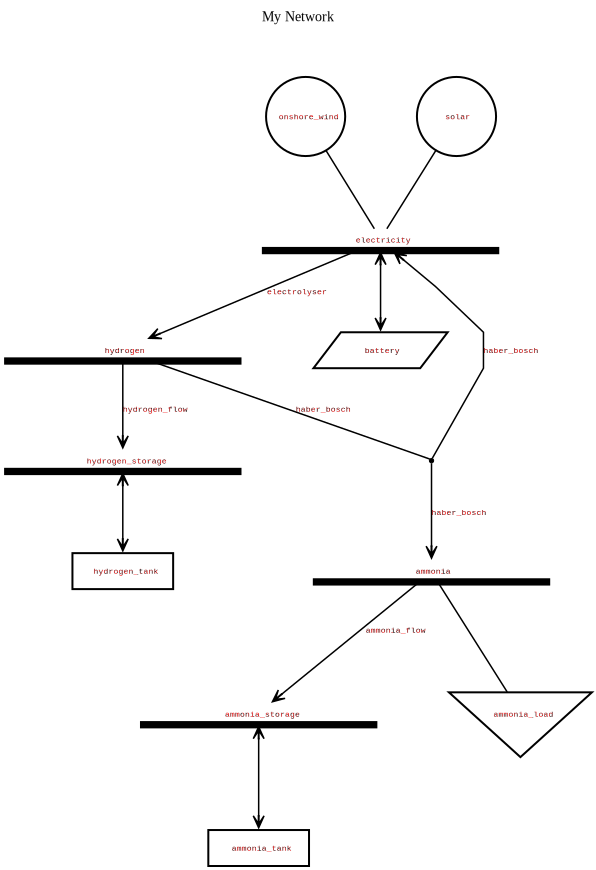

0

In [ ]:
pypsatopo.generate(n)

In [ ]:
# Solve network using cbc solver
n.optimize(pyomo=False, solver_name=solver)

Index(['hydrogen_flow', 'ammonia_flow', 'electrolyser'], dtype='object', name='Link')
Index(['hydrogen_flow', 'ammonia_flow', 'electrolyser'], dtype='object', name='Link')
INFO:linopy.model: Solve problem using Cbc solver
INFO:linopy.model:Solver options:
 - pyomo: False
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|████████████| 11/11 [00:00<00:00, 13.30it/s]
INFO:linopy.io: Writing time: 4.51s
INFO:linopy.solvers:Welcome to the CBC MILP Solver 
Version: 2.10.5 
Build Date: Apr 19 2021 

command line - cbc -printingOptions all -import /var/folders/g7/32_t5f316770d0s3z9qdv1tc0000gp/T/linopy-problem-hrx_27qf.lp -pyomo False -solve -solu /var/folders/g7/32_t5f316770d0s3z9qdv1tc0000gp/T/linopy-solve-xvu50aw_.sol (default strategy 1)
Option for printingOptions changed from normal to all
No match for pyomo - ? for list of commands
No match for False - ? for list of commands
Presolve 153149 (-144696) rows, 74320 (-39569) columns and 415647 (-219303) elements
Perturbin

('ok', 'optimal')

In [ ]:
n.stores_t.p

Store,hydrogen_tank,ammonia_tank
snapshot,,
2019-01-01 00:00:00,-4.138692,-7.997816
2019-01-01 01:00:00,15.966186,-7.997816
2019-01-01 02:00:00,49.668256,-7.997816
2019-01-01 03:00:00,102.248380,-7.997816
2019-01-01 04:00:00,65.669913,-7.997816
...,...,...
2019-12-31 19:00:00,3.400637,-7.997816
2019-12-31 20:00:00,-18.658882,-7.997816
2019-12-31 21:00:00,-43.562679,-7.997816


In [ ]:
pd.concat([n.stores_t.e,n.stores_t.p],axis=1).head()


Store,hydrogen_tank,ammonia_tank,hydrogen_tank,ammonia_tank
snapshot,,,,
2019-01-01 00:00:00,1013.68190,2410.5685,-4.138692,-7.997816
2019-01-01 01:00:00,997.71567,2418.5663,15.966186,-7.997816
2019-01-01 02:00:00,948.04742,2426.5642,49.668256,-7.997816
2019-01-01 03:00:00,845.79903,2434.5620,102.248380,-7.997816
2019-01-01 04:00:00,780.12912,2442.5598,65.669913,-7.997816


In [ ]:
n.generators.p_nom_opt

Generator
onshore_wind    473.27868
solar           498.06036
Name: p_nom_opt, dtype: float64

<Axes: xlabel='snapshot'>

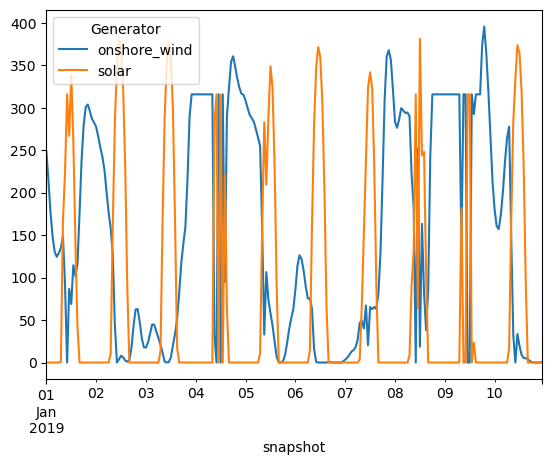

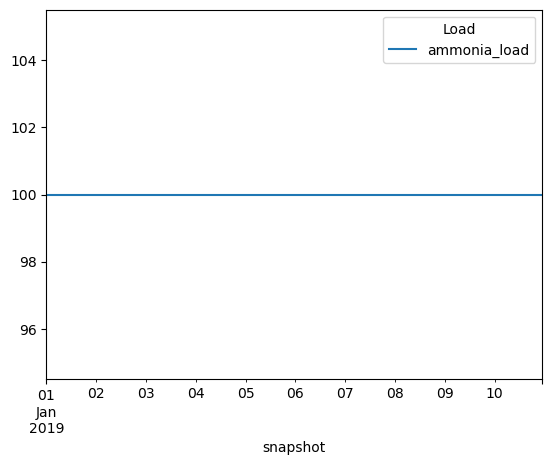

In [ ]:
# Inspect the interaction of different power plants to supply loads
n.generators_t.p[:24*10].plot()

# Inspect the interaction of ammonia load to supply loads
n.loads_t.p[:24*10].plot()

<Axes: xlabel='snapshot'>

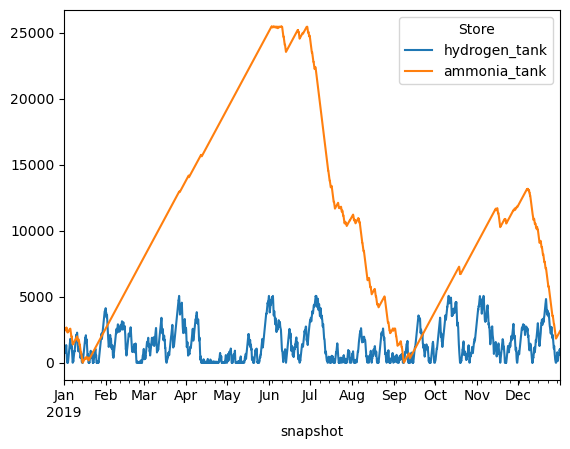

In [ ]:
# Inspect the change of energy capacity [MWh] in hydrogen_tank store to supply loads
n.stores_t.e[:24*365].plot()

<Axes: xlabel='snapshot'>

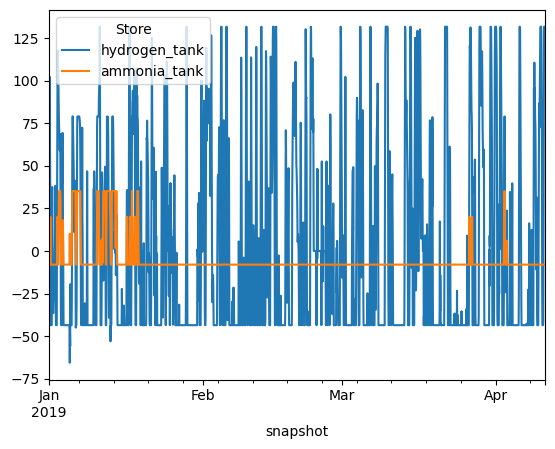

In [ ]:
# Inspect the change of power [MW] in hydrogen_tank store to supply loads
n.stores_t.p[:24*100].plot()

<Axes: xlabel='snapshot'>

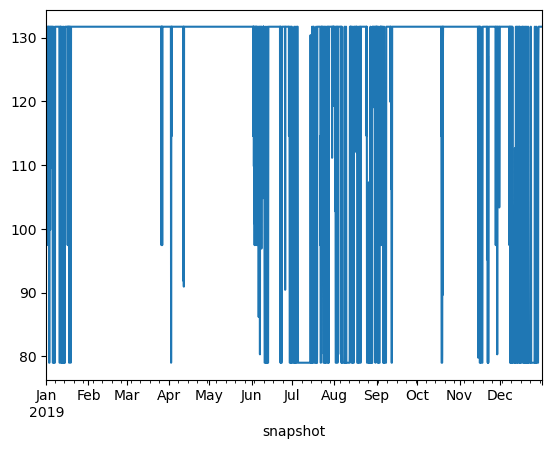

In [ ]:
# Inspect the electrolysis input power
#n.links_t.p0["electrolyser"][:24*10].plot()

# Inspect the Haber Bosch input power
n.links_t.p0["haber_bosch"][:24*365].plot()

<Axes: xlabel='snapshot'>

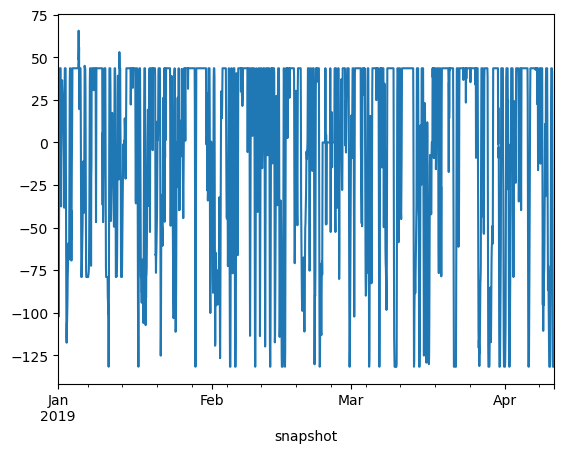

In [ ]:
# Inspect the charging flow
n.links_t.p0["hydrogen_flow"][:24*100].plot()

<Axes: xlabel='snapshot'>

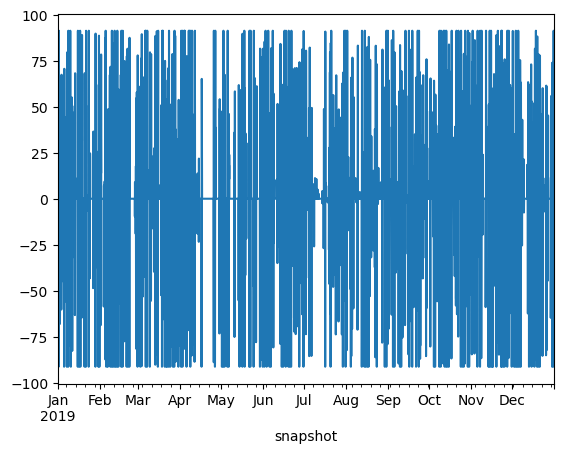

In [ ]:
# Inspect the charging flow
n.storage_units_t.p["battery"][:24*365].plot()

<Axes: xlabel='snapshot'>

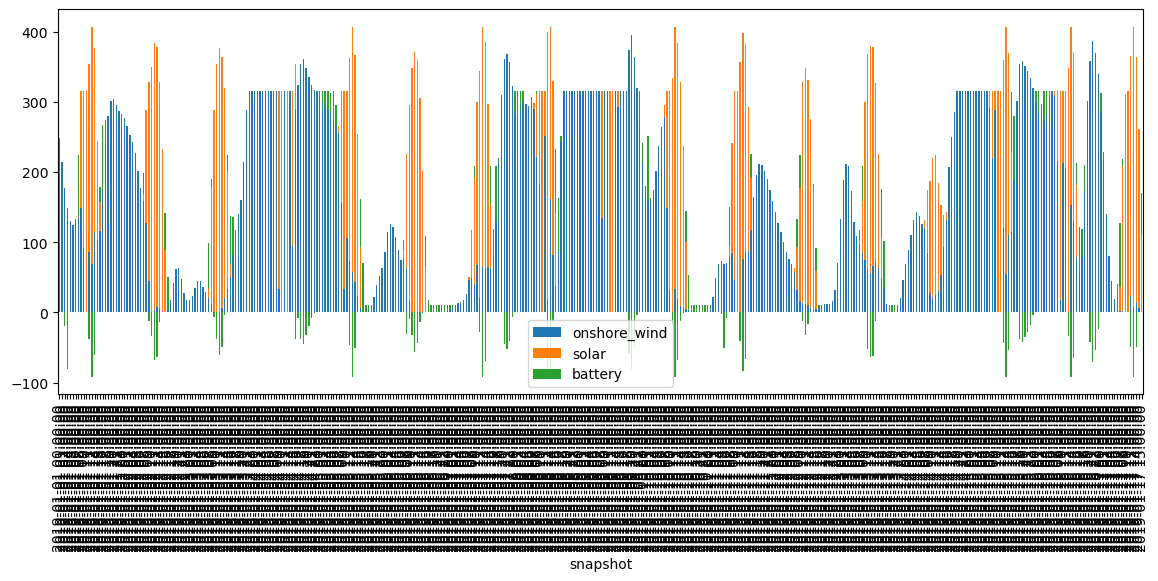

In [ ]:
# Inspect storage interaction with other powerplants to supply loads
load = n.loads_t.p
pow_gen = n.generators_t.p
storage = n.storage_units_t.p
result = pd.concat([pow_gen, storage, load], axis=1)

plot = result.loc[
    :, ~result.columns.isin(["ammonia_load"])
]  # drop load and nuclear columns
plot.iloc[:400, :].plot(kind="bar", stacked=True, figsize=(14, 5))

In [ ]:
n.statistics()

Optimal Capacity  Installed Capacity        Supply  \
Generator   solar               498.060360                 0.0  6.413011e+05   
            wind                473.278680                 0.0  1.324724e+06   
Link        Electrolyser        297.062870                 0.0  1.068291e+06   
            Haber-Bosch         131.704420                 0.0  8.760000e+05   
            ammonia              35.201311                 0.0  1.084507e+05   
            hydrogen            131.704420                 0.0  3.686808e+05   
Load        -                     0.000000                 0.0  0.000000e+00   
StorageUnit -                    91.332423                 0.0  4.963182e+04   
Store       ammonia           25460.487000                 0.0  5.422534e+04   
            hydrogen           5064.468300                 0.0  1.843404e+05   

                            Withdrawal      Dispatch  Transmission  \
Generator   solar         0.000000e+00  6.413011e+05      0.000000   
            wind          0.000000e+00  1.324724e+06      0.000000   
Link        Electrolyser  1.810662e+06 -7.423715e+05      0.000000   
            Haber-Bosch   1.219988e+06 -3.439881e+05      0.000000   
            ammonia       1.084507e+05  0.000000e+00     -0.000497   
            hydrogen      3.686808e+05  0.000000e+00     -0.001197   
Load        -             8.760000e+05 -8.760000e+05      0.000000   
StorageUnit -             5.329735e+04 -3.665525e+03      0.000000   
Store       ammonia       5.422534e+04  4.971467e-04      0.000000   
            hydrogen      1.843404e+05  1.196603e-03      0.000000   

                          Capacity Factor    Curtailment  Capital Expenditure  \
Generator   solar                0.146986  181502.442266         2.370607e+07   
            wind                 0.319525  272183.085456         3.147181e+07   
Link        Electrolyser         0.695801       0.000000         2.603175e+07   
            Haber-Bosch          0.925945       0.000000         9.902271e+06   
            ammonia              0.351698       0.000000         0.000000e+00   
            hydrogen             0.319555       0.000000         0.000000e+00   
Load        -                         NaN       0.000000         0.000000e+00   
StorageUnit -                    0.128650       0.000000         1.878800e+06   
Store       ammonia              0.427755       0.000000         2.900667e+06   
            hydrogen             0.291202       0.000000         8.102720e+06   

                          Operational Expenditure       Revenue  Market Value  
Generator   solar                    0.000000e+00  2.370607e+07  3.696559e+01  
            wind                     0.000000e+00  3.147181e+07  2.375726e+01  
Link        Electrolyser             0.000000e+00  2.603175e+07  2.436767e+01  
            Haber-Bosch              1.159202e+07  2.149429e+07  2.453686e+01  
            ammonia                 -4.971458e-04 -4.971693e-04 -4.584383e-09  
            hydrogen                -1.196603e-03 -1.196609e-03 -3.245536e-09  
Load        -                        0.000000e+00 -1.155861e+08           NaN  
StorageUnit -                        0.000000e+00  1.878800e+06  3.785474e+01  
Store       ammonia                  4.971467e-04  2.900668e+06  5.349284e+01  
            hydrogen                 1.196603e-03  8.102720e+06  4.395520e+01

In [ ]:
# Extract statistics
stats_df = n.statistics()


# Initialize a dictionary to store results
results = {}

# Ammonia output
value = stats_df.loc[("Link", "Haber-Bosch"), "Supply"]
MW_to_t_conversion = (1 / 5.2)
a_output = value / electricity_input_hb # Adjusted as needed
results["Total Ammonia Output"] = a_output

# Sum total CAPEX
total_capex = stats_df["Capital Expenditure"].sum()
results["Total CAPEX"] = total_capex

# Sum total OPEX
total_opex = stats_df["Operational Expenditure"].sum()
results["Total OPEX"] = total_opex

# Cost of Ammonia Production
cost_HB = stats_df.loc[("Link", "Haber-Bosch"), "Capital Expenditure"] + stats_df.loc[("Link", "Haber-Bosch"), "Operational Expenditure"]
MW_to_t_conversion = (1 / 5.2)
a_output = value  # Adjusted as needed
results["Total Ammonia Output"] = a_output


# Levelized Cost of Ammonia (LCOA)
LCOA = ((total_capex + total_opex) / a_output) / MW_to_t_conversion
results["Total LCOA (USD/t)"] = LCOA

# Convert dictionary to DataFrame
df_results = pd.DataFrame(list(results.items()), columns=["Description", "Value"])

# Define the XLSX file path
xlsx_file_path = "/Users/philip/Desktop/AGORA/China PyPSA LCOX/ code/data/LCOA_PyPSA_results.xlsx"

# Combine both DataFrames into one DataFrame with section headers
with pd.ExcelWriter(xlsx_file_path, engine="openpyxl", mode="a", if_sheet_exists="overlay") as writer:
    # Write the statistics DataFrame
    writer.sheets[f"{name}_{turbine}"] = None  # Ensure the sheet exists
    stats_df.to_excel(writer, sheet_name=f"{name}_{turbine}", startrow=0, index=True)

    # Write the results summary below the statistics DataFrame
    df_results.to_excel(writer, sheet_name=f"{name}_{turbine}", startrow=len(stats_df) + 3, index=False)

# Provide file path for download
print(f"Excel file saved at: {xlsx_file_path}")

Excel file saved at: /Users/philip/Desktop/AGORA/China PyPSA LCOX/ code/data/LCOA_PyPSA_results.xlsx


In [ ]:
# Exporting Ammonia network
#n.export_to_netcdf("/path/netcdf_ammonia.nc")

In [ ]:
"""
# notes
1. update numbers
1.1. update solar #check
1.2. update on_wind #check
1.3. update electrolyser #check (not sure if satisfactory, ramp up?)
1.4. update haber_bosch #check (not sure if satisfactory, ramp up?)
1.5. update hydrogen storage #check
1.6. update ammonia tank ? 
1.7. update battery storage #check (better data available?) 

2. create new wind and solar profiles for China #check
2.1 ninja for wind
2.2 solar atlas for solar?

# questions: 
1. Should there be a curtailment option for solar and wind, or an option to sell excess power to the power market? 
1.1 I am raising this question, as the electrolysis is primarily only running when solar energy is available, instead of more constantly, which seams the intuitive way, given that RES is so cheap?
2. both electrolyser and haber-bosch currently behave according to the intermittance of wind (and solar but less so) 
3. The battery seems to not connect, something seems wrong here. I do wonder if the unit for the capex shouldnt be MWh and not MW? 
4. How do I now determine the LCOA of the whole model? I haven't quite understood how that works.
"""

"\n# notes\n1. update numbers\n1.1. update solar #check\n1.2. update on_wind #check\n1.3. update electrolyser #check (not sure if satisfactory, ramp up?)\n1.4. update haber_bosch #check (not sure if satisfactory, ramp up?)\n1.5. update hydrogen storage #check\n1.6. update ammonia tank ? \n1.7. update battery storage #check (better data available?) \n\n2. create new wind and solar profiles for China #check\n2.1 ninja for wind\n2.2 solar atlas for solar?\n\n# questions: \n1. Should there be a curtailment option for solar and wind, or an option to sell excess power to the power market? \n1.1 I am raising this question, as the electrolysis is primarily only running when solar energy is available, instead of more constantly, which seams the intuitive way, given that RES is so cheap?\n2. both electrolyser and haber-bosch currently behave according to the intermittance of wind (and solar but less so) \n3. The battery seems to not connect, something seems wrong here. I do wonder if the unit fo

In [ ]:
#References: 
#1- Agora Energiewende (2024). PyPSA Agora H2 Training. https://github.com/agoenergy/pypsa-agora-h2-training/tree/main
#2- Agora Energy Transition China (2025). China green LCO-X dataset. 
#3- wind and solar profiles: https://www.renewables.ninja/
#4 - Bodke, N., Pedersen, T. Andresen, G. (2021). Optimal Scheduling of Flexible Power-to-X Technologies in the Day-ahead Electricity Market. https://arxiv.org/pdf/2110.09800 